In [1]:
import os
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import joblib
from sklearn.pipeline import Pipeline
#from dask_ml.preprocessing import StandardScaler
#from dask_ml.decomposition import PCA

#from dask_ml.xgboost import XGBRegressor
#from dask_ml.linear_model import LogisticRegression
#from dask_ml.linear_model import LinearRegression
#from sklearn.linear_model import Ridge

import h5py
import keras
from keras.layers.core import Dropout

import geopandas
from rasterio import features
from affine import Affine

import dask
import xarray as xr
from dask.diagnostics import ProgressBar

Using Theano backend.


In [2]:
import sys
print(sys.executable)

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/bin/python3


In [3]:
def sfloat(f):
    return str(float(f))
def sint(i):
    return str(int(i))

In [4]:
def read_glofas_danube():
    glofas = xr.open_dataset('../data/danube/glofas_reanalysis_danube_1981-2002.nc')
    glofas = glofas.rename({'lat': 'latitude', 'lon': 'longitude'})  # to have the same name like in era5
    glofas = shift_time(glofas, -dt.timedelta(days=1))  # the discharge is the mean of the previous 24h of the timestamp
    return glofas

In [5]:
def shift_time(ds, value):
    ds.coords['time'].values = pd.to_datetime(ds.coords['time'].values) + value
    return ds

In [6]:
def select_riverpoints(glofas):
    return (glofas['dis'] > 5)

In [7]:
def get_mask_of_basin(da, kw_basins='Danube'):
    """
    Parameters:
    -----------
        da : xr.DataArray
            contains the coordinates
        kw_basins : str
            identifier of the basin in the basins dataset
    """
    def transform_from_latlon(lat, lon):
        lat = np.asarray(lat)
        lon = np.asarray(lon)
        trans = Affine.translation(lon[0], lat[0])
        scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
        return trans * scale

    def rasterize(shapes, coords, fill=np.nan, **kwargs):
        """Rasterize a list of (geometry, fill_value) tuples onto the given
        xray coordinates. This only works for 1d latitude and longitude
        arrays.
        """
        transform = transform_from_latlon(coords['latitude'], coords['longitude'])
        out_shape = (len(coords['latitude']), len(coords['longitude']))
        raster = features.rasterize(shapes, out_shape=out_shape,
                                    fill=fill, transform=transform,
                                    dtype=float, **kwargs)
        return xr.DataArray(raster, coords=coords, dims=('latitude', 'longitude'))
    
    # this shapefile is from natural earth data
    # http://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/
    shp2 = '/raid/home/srvx7/lehre/users/a1303583/ipython/ml_flood/data/drainage_basins/Major_Basins_of_the_World.shp'
    basins = geopandas.read_file(shp2)
#    print(basins)
    single_basin = basins.query("NAME == '"+kw_basins+"'").reset_index(drop=True)
#    print(single_basin)
    shapes = [(shape, n) for n, shape in enumerate(single_basin.geometry)]

    da['basins'] = rasterize(shapes, da.coords)
    da = da.basins == 0
    return da.drop('basins')
    

In [24]:
def select_upstream(glofas, lat, lon, basin='Danube'):
    dis_box_mean = glofas['dis'].mean('time')
    da = dis_box_mean
    
    # longitude condition
    is_west = (~np.isnan(dis_box_mean.where(dis_box_mean.longitude <= lon))).astype(bool)

    river_min_discharge = 20
    # mask_box_mean_greater = dis_box_mean > river_min_discharge
    mask_box_mean_greater = (~np.isnan(dis_box_mean.where(dis_box_mean > river_min_discharge))).astype(bool)
    
    mask_basin = get_mask_of_basin(dis_box_mean, kw_basins=basin)
    #mask_basin = ~np.isnan(tmp).astype(bool)
    
    #dlat = dis_box_mean.latitude[1]-dis_box_mean.latitude[0]
    #dlon = dis_box_mean.longitude[1]-dis_box_mean.longitude[0]
    nearby_mask = dis_box_mean*0.
    nearby_mask.loc[dict(latitude=slice(lat+1, lat-1), 
                         longitude=slice(lon-1, lon+1))] = 1.
    nearby_mask = nearby_mask.astype(bool)
    #plt.imshow(nearby_mask.astype(int))
    #plt.show()
    
    mask = mask_box_mean_greater & mask_basin & is_west & nearby_mask
    mask = mask.drop(['time', 'basins'])  # time and basins dimension make no sense here
    return mask

In [9]:
def train(pipe, X_train, y_train, X_valid, y_valid):
    history = pipe.fit(X_train, y_train,
                       model__validation_data=(X_valid, #.values, 
                                               y_valid)) #.values.reshape(-1,1)))

    h = history.named_steps['model'].model.history

    # Plot training & validation loss value
    plt.figure()
    plt.plot(h.history['loss'], label='loss')
    plt.plot(h.history['val_loss'], label='val_loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend() #['Train', 'Test'], loc='upper left')
    plt.gca().set_yscale('log')
    plt.show()

In [10]:
def add_shifted_predictors(ds, shifts, variables='all'):
    """Adds additional variables to an array which are shifted in time.
    
    Parameters
    ----------
    ds : xr.Dataset
    shifts : list of integers
    variables : str or list
    """
    if variables == 'all': 
        variables = ds.data_vars
        
    for var in variables:
        for i in shifts:
            if i == 0: continue  # makes no sense to shift by zero
            newvar = var+'-'+str(i)
            ds[newvar] = ds[var].shift(time=i)
    return ds

In [11]:
def preprocess_reshape_flowmodel(X_dis, y_dis):
    """Reshape, merge predictor/predictand in time, drop nans."""
    X_dis = X_dis.to_array(dim='time_feature')  
    #print('X before feature-stacking', X_dis)
    X_dis = X_dis.stack(features=['latitude', 'longitude', 'time_feature'])
    #print('X before featuredrop', X_dis)
    Xar = X_dis.dropna('features', how='all')
    
    yar = y_dis
    yar = yar.drop(['latitude', 'longitude'])
    yar.coords['features'] = 'dis'
    
    #print('X, y before concat for time nan dropping', Xar, yar)
    Xy = xr.concat([Xar, yar], dim='features')
    Xyt = Xy.dropna('time', how='any')  # drop them as we cannot train on nan values
    time = Xyt.time
    
    Xda = Xyt[:,:-1]
    yda = Xyt[:,-1]
    return Xda, yda, time

In [12]:
def add_time(vector, time, name=None):
    """Converts arrays to xarrays with a time coordinate."""
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)

class FlowModel(object):
    def __init__(self, **kwargs):
        model = keras.models.Sequential()
        self.cfg = kwargs
        
        model.add(keras.layers.BatchNormalization())
        
        model.add(keras.layers.Dense(8,
                                  kernel_initializer='normal', 
                                  bias_initializer='zeros',
                                  activation='relu')) #('sigmoid'))
        #model.add(Dropout(self.cfg.get('dropout')))
        #model.add(keras.layers.Dense(32))
        #model.add(keras.layers.Activation('sigmoid'))
        #model.add(Dropout(self.cfg.get('dropout')))
        #model.add(keras.layers.Dense(16))
        #model.add(keras.layers.Activation('sigmoid'))
        #model.add(Dropout(self.cfg.get('dropout')))
        #model.add(keras.layers.Dense(8))
        #model.add(keras.layers.Activation('sigmoid'))
        #model.add(Dropout(self.cfg.get('dropout')))
        model.add(keras.layers.Dense(1, activation='linear'))
        #                     bias_initializer=keras.initializers.Constant(value=9000)))
        
        #ha = self.cfg.get('hidden_activation')

        #for N_nodes in self.cfg.get('N_hidden_nodes'):
        #        
        #    model.add(hidden)
        #    model.add(ha.copy())
        #    
        #    if self.cfg.get('dropout'):
        #        model.add(Dropout(self.cfg.get('dropout')))#

        #outputlayer = keras.layers.Dense(1, activation='linear')

        #optimizer_name, options_dict = self.cfg.get('optimizer')
        #optimizer = getattr(keras.optimizers, optimizer_name)(**options_dict)
        #optimizer = keras.optimizers.SGD(lr=0.01)
        rmsprop = keras.optimizers.RMSprop(lr=.05)
        sgd = keras.optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.8, nesterov=True)

        model.compile(loss=self.cfg.get('loss'), 
                      optimizer=rmsprop)
        self.model = model

        self.callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                            min_delta=1, patience=10, verbose=0, mode='auto',
                            baseline=None, restore_best_weights=True),
                         keras.callbacks.ModelCheckpoint(self.cfg.get('filepath'), 
                            monitor='val_loss', verbose=0, save_best_only=True, 
                            save_weights_only=False, mode='auto', period=1),]

    def predict(self, Xda, name=None):
        a = self.model.predict(Xda.values).squeeze()
        return add_time(a, Xda.time, name=name)

    def fit(self, Xda, yda, **kwargs):
        return self.model.fit(Xda.values, yda.values.reshape(-1,1),
                              epochs=self.cfg.get('epochs', None),
                              batch_size=self.cfg.get('batch_size', None),
                              callbacks=self.callbacks,
                              verbose=0,
                              **kwargs)

In [13]:
def create_FlowModel(filepath):
    mlp_kws = dict(optimizer=('sgd', dict(lr=1)),
                   loss='mean_squared_error',
                   #N_hidden_nodes=(4,4),
                   #hidden_activation=keras.layers.Activation('sigmoid'), #keras.layers.ReLU(), #-LeakyReLU(alpha=0.3), #'relu',
                   #output_activation='linear',
                   #bias_initializer='random_uniform',
                   batch_size=128,
                   dropout=0., #.25,
                   epochs=1000,
                   filepath = filepath,
                  )
    
    return Pipeline([#('scaler', StandardScaler()),
                     #('pca', PCA(n_components=2)),
                     ('model', FlowModel(**mlp_kws)),],
                     verbose=False)

In [14]:
static = xr.open_dataset('../data/danube/era5_slt_z_slor_lsm_stationary_field.nc')

In [15]:
#era5 = xr.open_dataset('../data/usa/era5_lsp_cp_1981-2017_daysum.nc')
#era5 = shift_time(era5, -dt.timedelta(hours=23))

era5 = xr.open_dataset('../data/danube/era5_danube_pressure_and_single_levels.nc')

In [16]:
glofas = read_glofas_danube()

In [17]:
glofas = glofas.isel(time=slice(0, 365*10))  # just to reduce the amount of data

if 'tp' in era5:
    tp = era5['tp']
else:
    tp = (era5['cp']+era5['lsp'])*1000
    tp.name = 'total precip [mm]'
tp = tp.interp(latitude=glofas.latitude,
               longitude=glofas.longitude)

## prepare training data for the FlowModel
### features = discharge upstream (t-1, ... t-3)
### target = discharge (t)


In [18]:
shifts = range(1,4)
X = add_shifted_predictors(glofas, shifts, variables='all')
X = X.drop('dis')  # current dis is to be predicted, is not a feature

y = glofas['dis']  # just this variable as dataarray

### for rgp in riverpoints:

In [19]:
N_train = 365*5
N_valid = 365*1

fm_path = './flowmodel_lat_lon.h5'

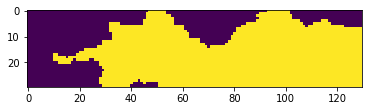

48.25 8.050000000000011 is spring.
48.15 8.050000000000011 is spring.
48.05 8.050000000000011 is spring.
48.25 8.150000000000034 is spring.
48.15 8.150000000000034 is spring.
48.05 8.150000000000034 is spring.
48.15 8.250000000000028 is spring.
48.05 8.250000000000028 is spring.
47.95 8.250000000000028 is spring.
48.15 8.350000000000023 is spring.
48.05 8.350000000000023 is spring.
47.95 8.350000000000023 is spring.
48.15 8.450000000000017 is spring.
48.05 8.450000000000017 is spring.
47.95 8.450000000000017 is spring.
48.05 8.550000000000011 is spring.
47.95 8.550000000000011 is spring.
48.15 8.650000000000034 is spring.
48.05 8.650000000000034 is spring.
47.95 8.650000000000034 is spring.
48.15 8.750000000000028 is spring.
48.05 8.750000000000028 is spring.
48.15 8.850000000000023 is spring.
48.25 8.950000000000017 is spring.
48.15 8.950000000000017 is spring.
48.05 8.950000000000017 is spring.
48.35 9.050000000000011 is spring.
48.25 9.050000000000011 is spring.
48.15 9.050000000000

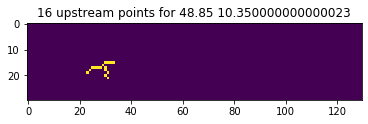

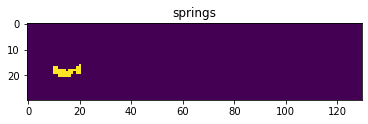

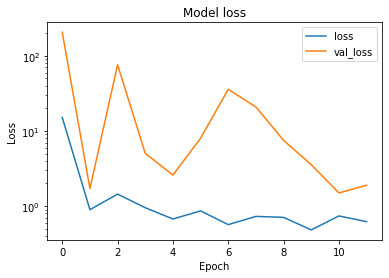

48.75 10.350000000000023 is danube river -> train flowmodel


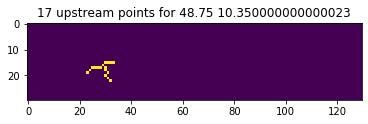

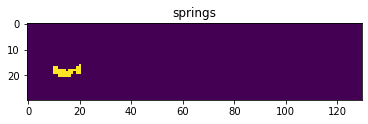

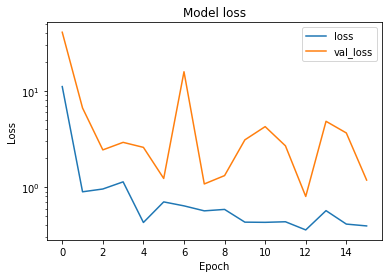

48.65 10.350000000000023 is danube river -> train flowmodel


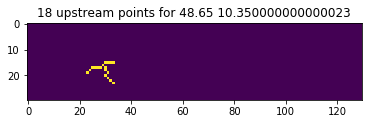

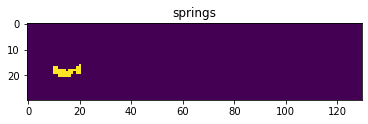

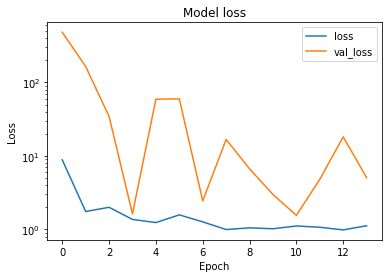

48.55 10.350000000000023 is danube river -> train flowmodel


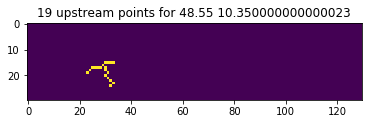

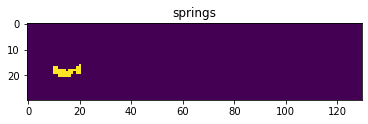

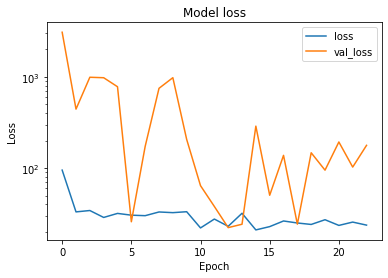

48.45 10.350000000000023 is danube river -> train flowmodel


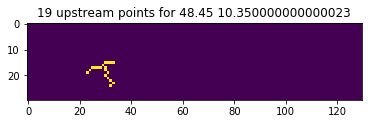

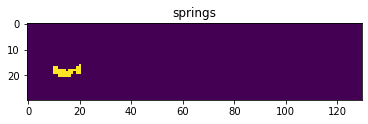

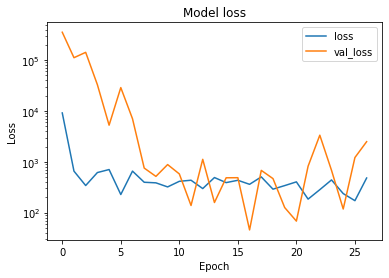

48.35 10.350000000000023 is danube river -> train flowmodel


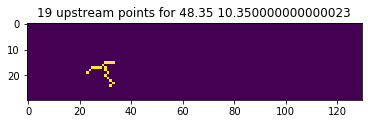

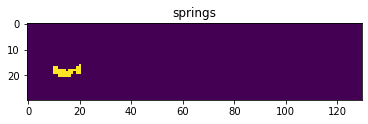

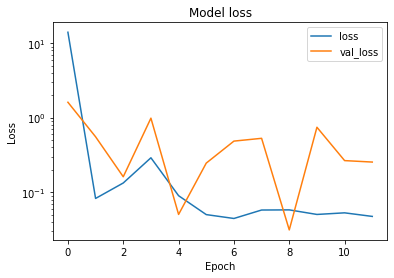

48.25 10.350000000000023 is danube river -> train flowmodel


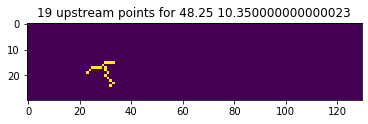

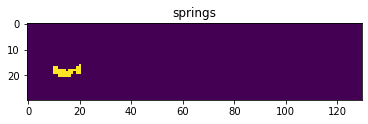

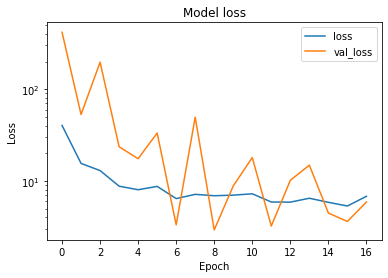

48.15 10.350000000000023 is danube river -> train flowmodel


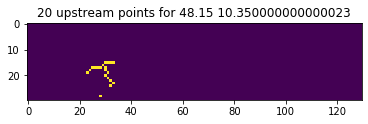

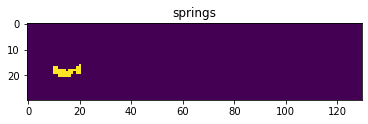

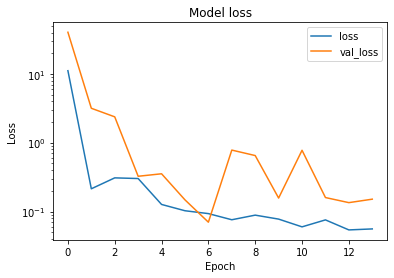

48.05 10.350000000000023 is danube river -> train flowmodel


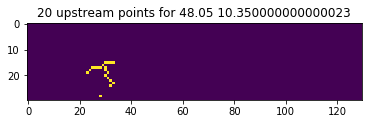

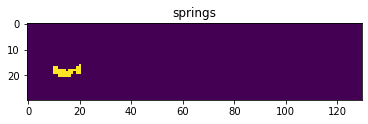

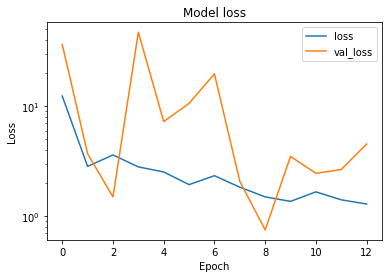

47.95 10.350000000000023 is danube river -> train flowmodel


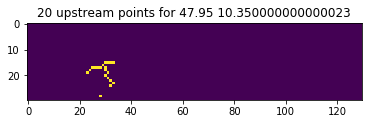

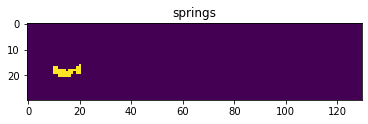

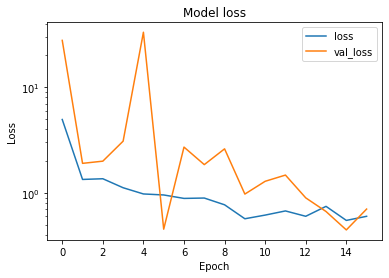

47.85 10.350000000000023 is danube river -> train flowmodel


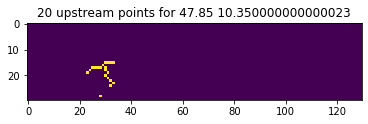

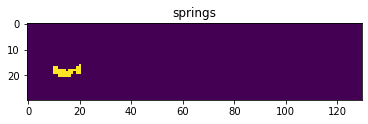

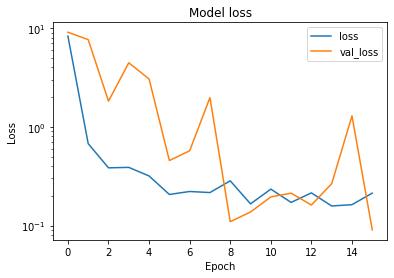

47.75 10.350000000000023 is danube river -> train flowmodel


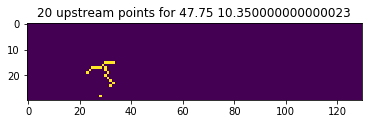

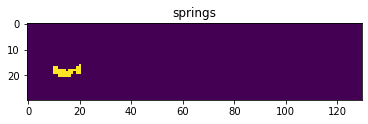

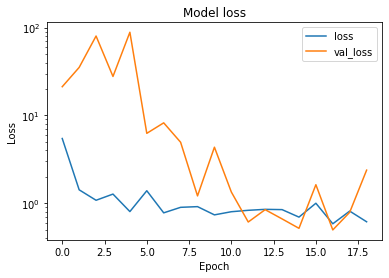

47.65 10.350000000000023 is danube river -> train flowmodel


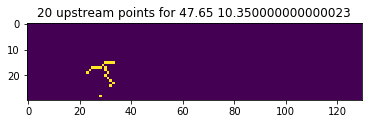

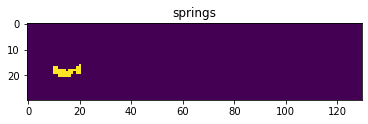

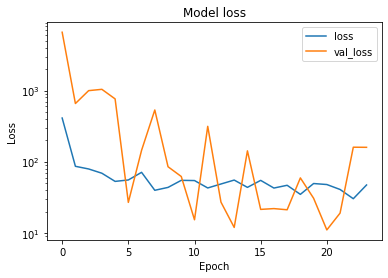

47.55 10.350000000000023 is danube river -> train flowmodel


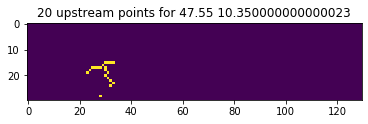

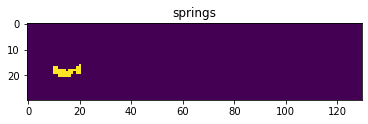

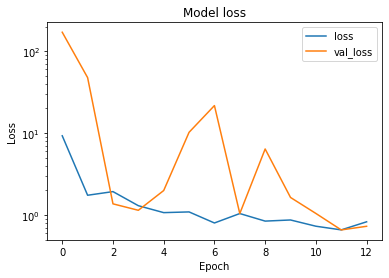

47.45 10.350000000000023 is danube river -> train flowmodel


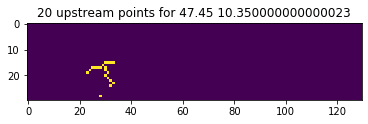

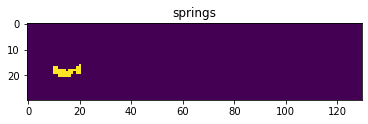

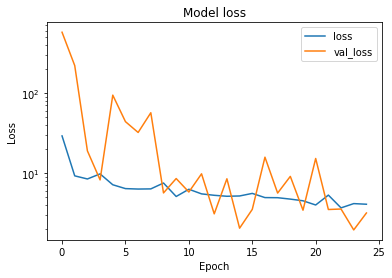

47.35 10.350000000000023 is danube river -> train flowmodel


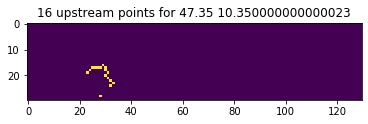

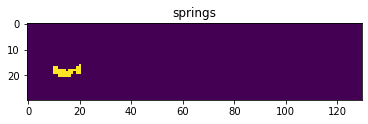

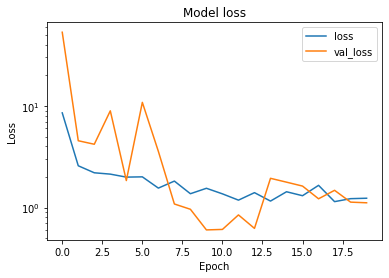

47.25 10.350000000000023 is danube river -> train flowmodel


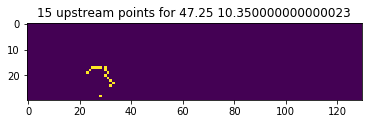

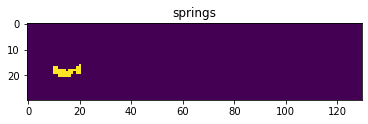

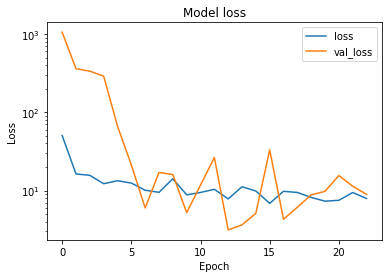

47.15 10.350000000000023 is danube river -> train flowmodel


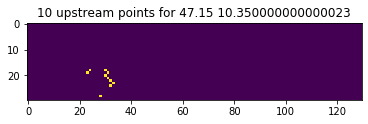

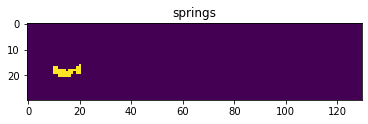

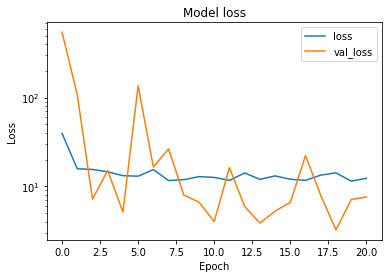

47.05 10.350000000000023 is danube river -> train flowmodel


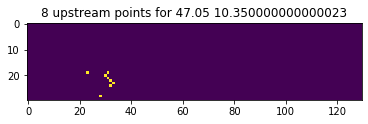

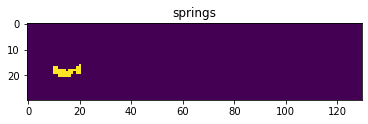

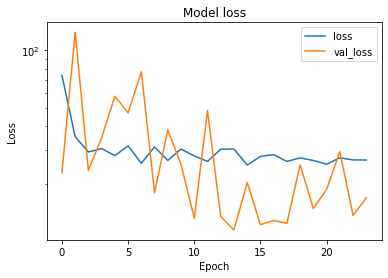

49.45 10.450000000000017 is danube river -> train flowmodel


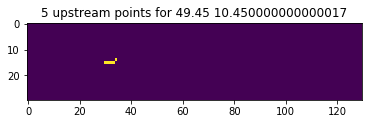

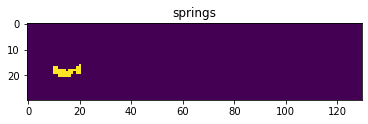

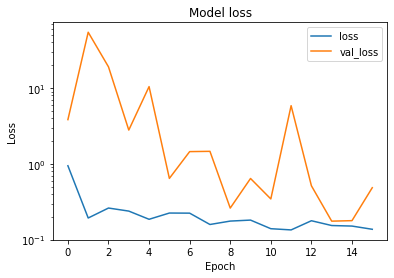

49.35 10.450000000000017 is danube river -> train flowmodel


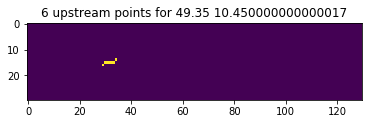

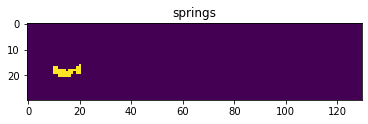

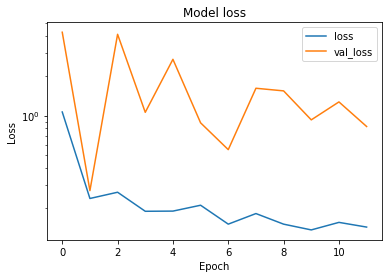

49.25 10.450000000000017 is danube river -> train flowmodel


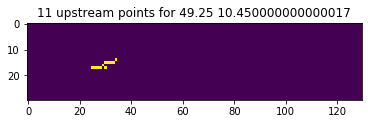

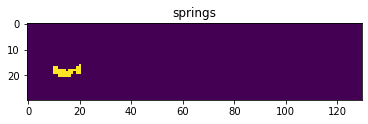

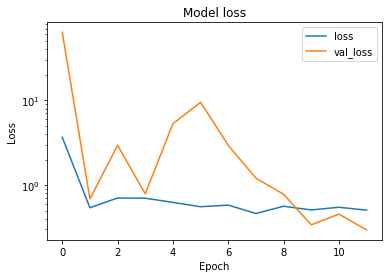

49.15 10.450000000000017 is danube river -> train flowmodel


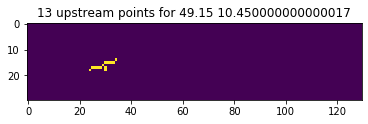

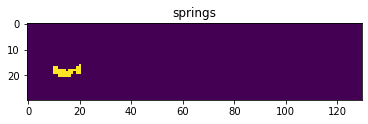

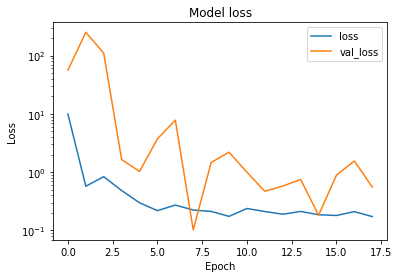

49.05 10.450000000000017 is danube river -> train flowmodel


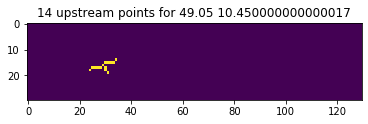

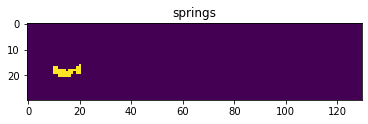

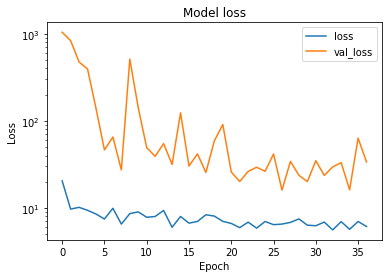

48.95 10.450000000000017 is danube river -> train flowmodel


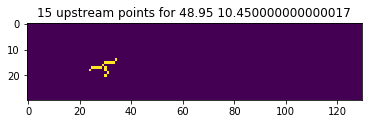

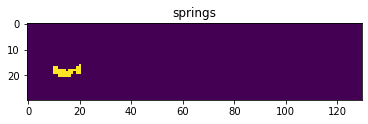

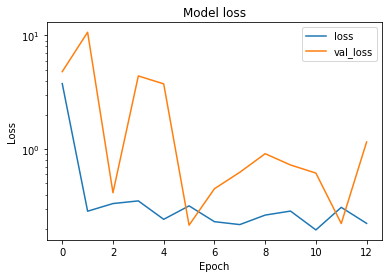

48.85 10.450000000000017 is danube river -> train flowmodel


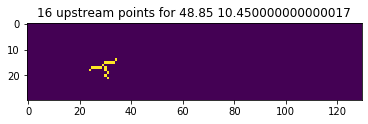

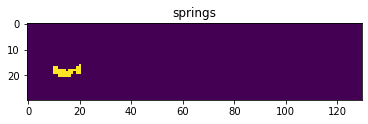

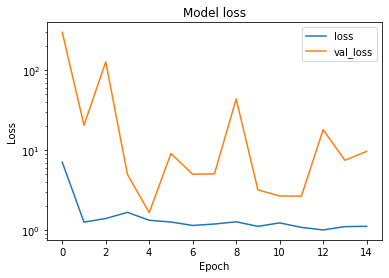

48.75 10.450000000000017 is danube river -> train flowmodel


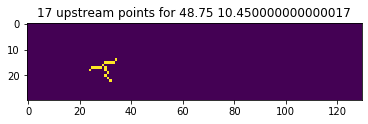

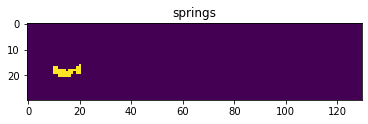

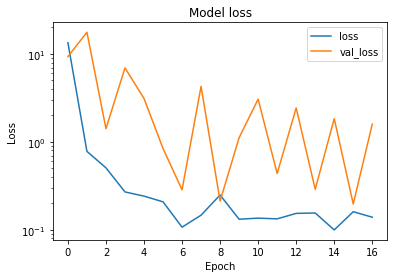

48.65 10.450000000000017 is danube river -> train flowmodel


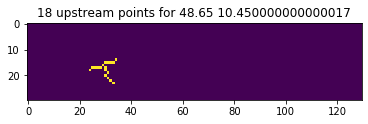

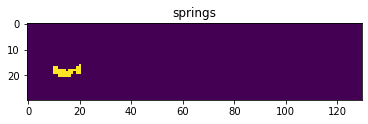

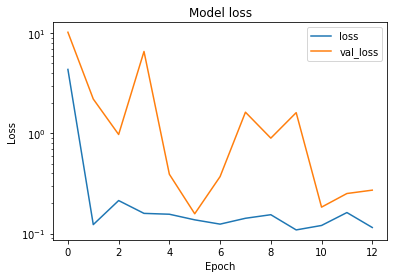

48.55 10.450000000000017 is danube river -> train flowmodel


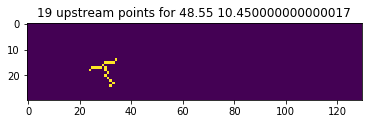

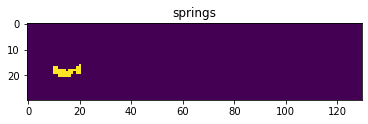

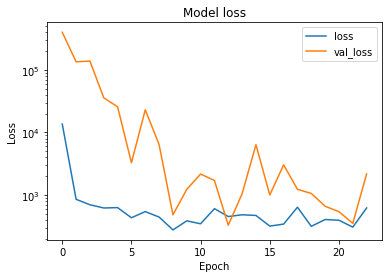

48.45 10.450000000000017 is danube river -> train flowmodel


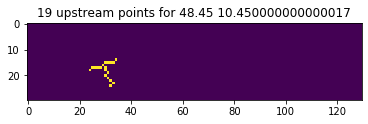

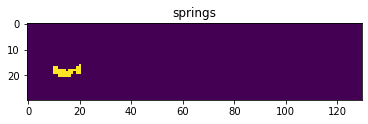

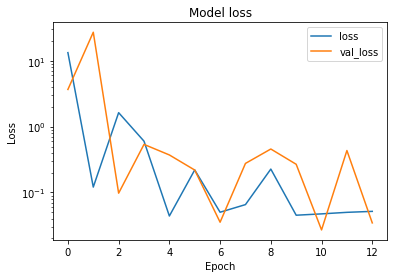

48.35 10.450000000000017 is danube river -> train flowmodel


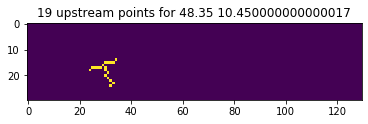

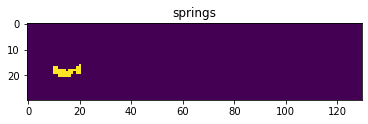

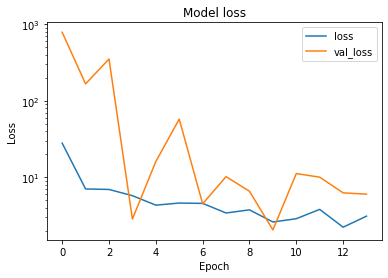

48.25 10.450000000000017 is danube river -> train flowmodel


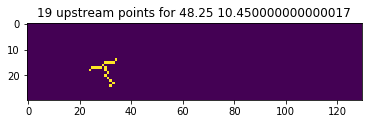

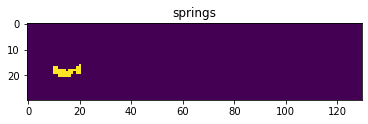

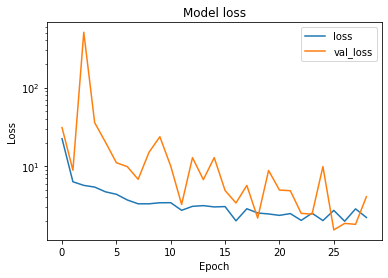

48.15 10.450000000000017 is danube river -> train flowmodel


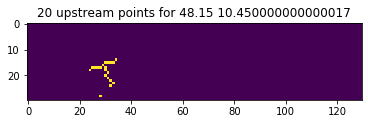

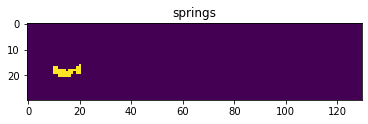

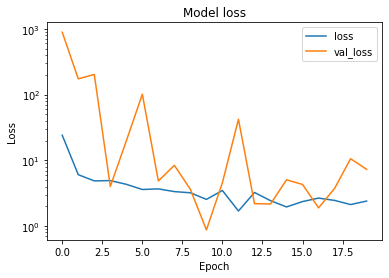

48.05 10.450000000000017 is danube river -> train flowmodel


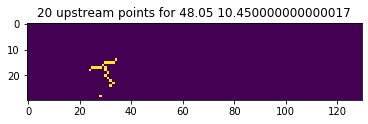

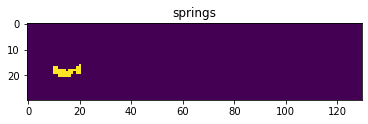

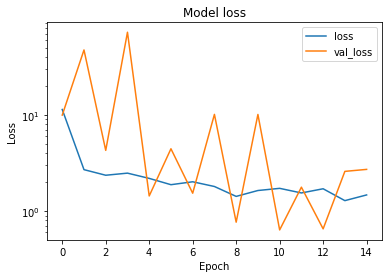

47.95 10.450000000000017 is danube river -> train flowmodel


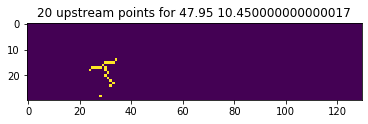

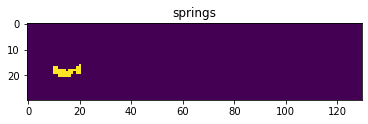

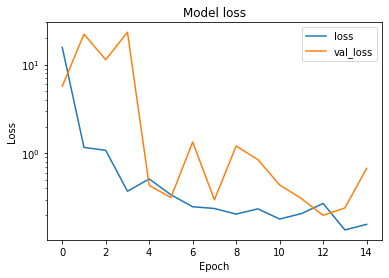

47.85 10.450000000000017 is danube river -> train flowmodel


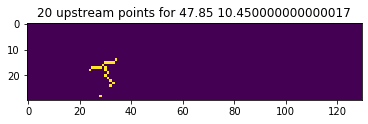

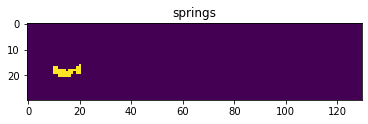

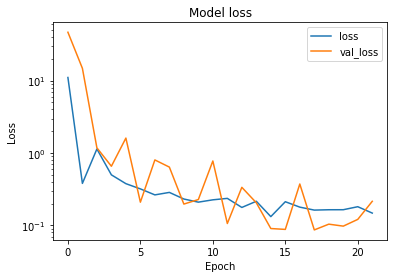

47.75 10.450000000000017 is danube river -> train flowmodel


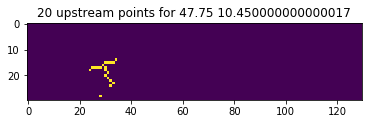

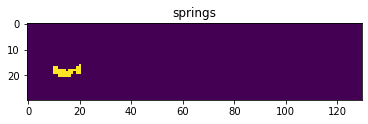

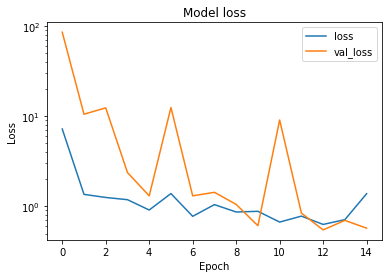

47.65 10.450000000000017 is danube river -> train flowmodel


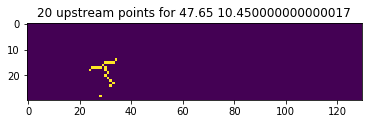

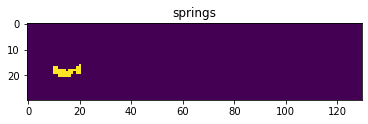

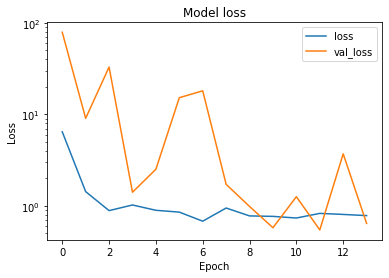

47.55 10.450000000000017 is danube river -> train flowmodel


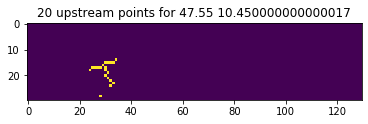

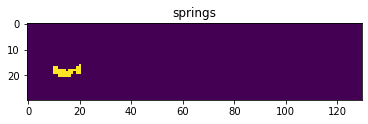

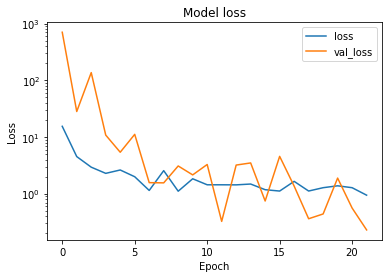

47.45 10.450000000000017 is danube river -> train flowmodel


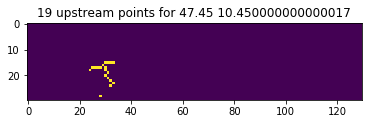

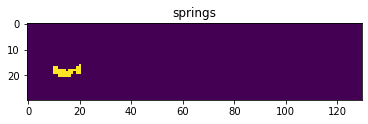

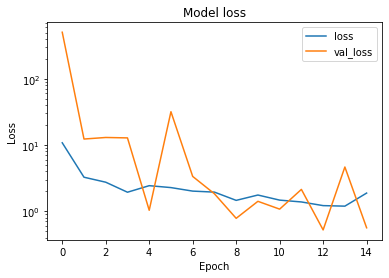

47.35 10.450000000000017 is danube river -> train flowmodel


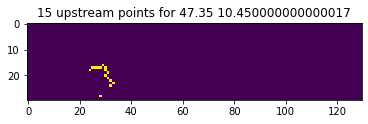

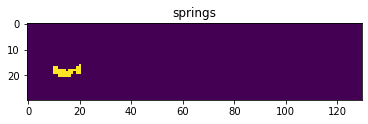

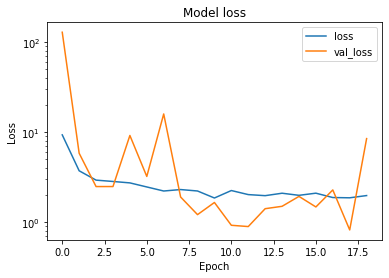

47.25 10.450000000000017 is danube river -> train flowmodel


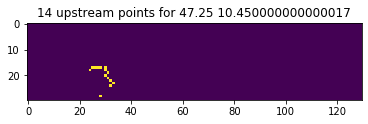

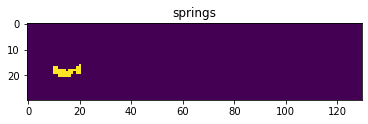

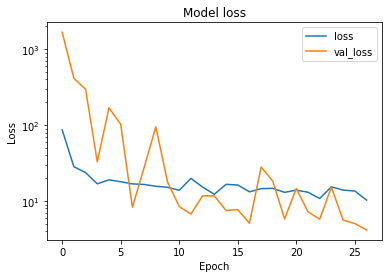

47.15 10.450000000000017 is danube river -> train flowmodel


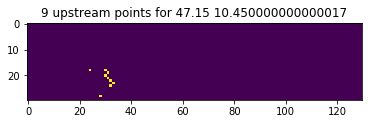

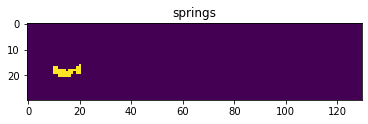

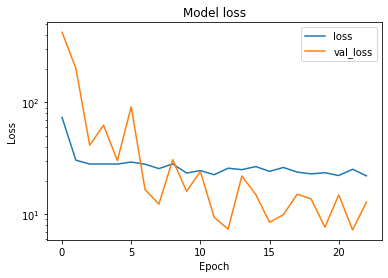

47.05 10.450000000000017 is danube river -> train flowmodel


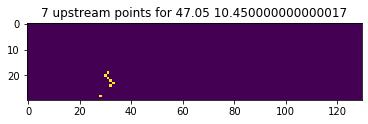

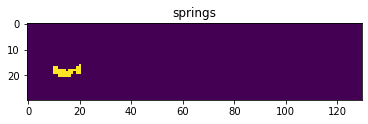

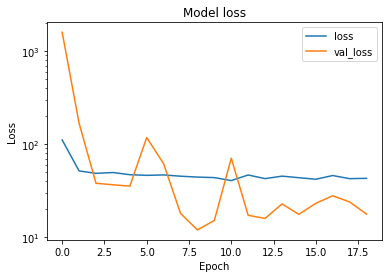

49.45 10.550000000000011 is danube river -> train flowmodel


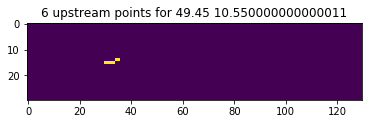

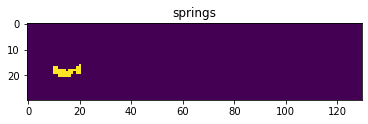

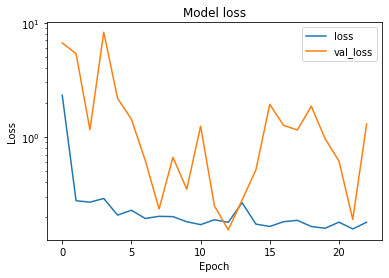

49.35 10.550000000000011 is danube river -> train flowmodel


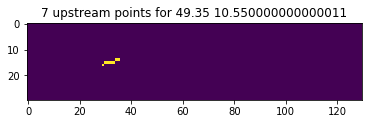

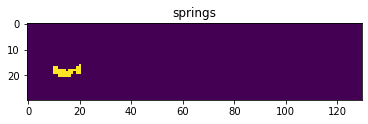

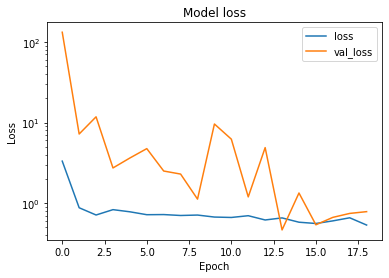

49.25 10.550000000000011 is danube river -> train flowmodel


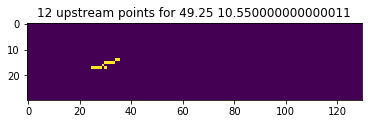

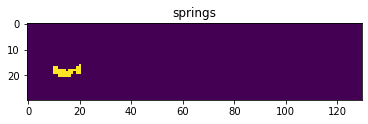

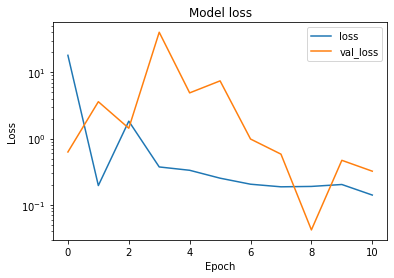

49.15 10.550000000000011 is danube river -> train flowmodel


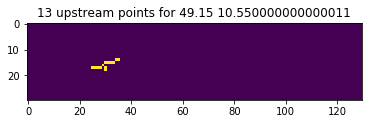

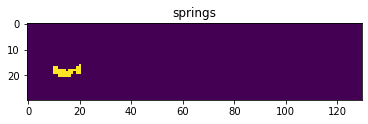

KeyboardInterrupt: 

In [25]:
#riverpoints = select_riverpoints(glofas)
danube_gridpoints = get_mask_of_basin(glofas['dis'].isel(time=0), 'Danube')

plt.imshow(danube_gridpoints.astype(int))
plt.show()

mask_springs = glofas['dis'].isel(time=0)
mask_springs.values[:] = 0.


for lon in danube_gridpoints.longitude:
    for lat in danube_gridpoints.latitude:
        #print(danube_gridpoints.sel(latitude=lat, longitude=lon))
        if danube_gridpoints.sel(latitude=lat, longitude=lon) == 1:
            
            lats, lons = sfloat(lat), sfloat(lon)
            modpath = fm_path.replace('lat', lats).replace('lon', lons)

            upstream = select_upstream(glofas, lat, lon, basin='Danube')

            N_upstream = int(upstream.sum())
            if N_upstream < 3:
                print(lats, lons, 'is spring.')
                mask_springs.loc[dict(latitude=lat, longitude=lon)] = 1.

                #plt.imshow(mask_springs.astype(int))
                #plt.title('springs')
                #plt.show()
            else:
                if not os.path.isfile(modpath):
                    print(lats, lons, 'is danube river -> train flowmodel')
                    plt.imshow(upstream.astype(int))
                    plt.title(str(N_upstream)+' upstream points for '+lats+' '+lons)
                    plt.show()
                    
                    plt.imshow(mask_springs.astype(int))
                    plt.title('springs')
                    plt.show()

                    Xt = X.where(upstream, drop=True)
                    yt = y.sel(latitude=float(lat), longitude=float(lon))

                    #print(Xt, upstream)
                    Xda, yda, time = preprocess_reshape_flowmodel(Xt, yt)

                    X_train = Xda[:N_train,:]
                    y_train = yda[:N_train]
                    X_valid = Xda[N_train:N_train+N_valid,:]
                    y_valid = yda[N_train:N_train+N_valid]


                    pipe = create_FlowModel(modpath)

                    train(pipe, X_train, y_train, X_valid, y_valid)

# Preprocessing routines - Summary

In [ ]:
X_valid.values.shape

In [ ]:
fig, ax = plt.subplots(figsize=(24,5))
minpred = X_train.min('features')
maxpred = X_train.max('features')

minpred.plot(ax=ax, linestyle='--', label='predictor-min')
maxpred.plot(ax=ax, linestyle='--', label='predictor-max')


dis[:,i,j].to_pandas().plot(ax=ax, label='dis-reanalysis')
y_train_pred.plot(ax=ax, marker='.', lw=0)

plt.legend()
plt.gca().set_xlim(dt.datetime(1981,1,1), y_train_pred.time.values[-1]) 

In [ ]:
fig, ax = plt.subplots(figsize=(24,5))
minpred = add_time(Xda.min(axis=1), time)
maxpred = add_time(Xda.max(axis=1), time)

minpred.plot(ax=ax, linestyle='--', label='predictor-min')
maxpred.plot(ax=ax, linestyle='--', label='predictor-max')

dis[:,i,j].to_pandas().plot(ax=ax, label='dis-reanalysis')
y_valid_pred.plot(ax=ax, marker='.', lw=0)

plt.legend()
plt.gca().set_xlim(y_valid_pred.time.values[0], y_valid_pred.time.values[-1]) 

## Verification

Is the NN model better than using the max value of all predictors?

In [ ]:
def to_5yr(dis):
    return dis/glofas_rl['rl5'].sel(latitude=dis.latitude, longitude=dis.longitude)

In [ ]:
((y_train_pred-y_train)/y_train*100).plot(label=)
X_train.max('features').plot(label='max_feature')